Text classification

In [1]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter, OrderedDict
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hrishikesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hrishikesh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
import kagglehub

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /home/hrishikesh/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [5]:
import os
df = pd.read_csv(os.path.join(path, 'IMDB Dataset.csv'))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Creating a CNN for text classification

In [6]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Conv1d(embed_dim, 128, 3)
        self.conv2 = nn.Conv1d(128, 64, 3)
        self.conv3 = nn.Conv1d(64, 32, 3)

        self.pool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(32 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


In [7]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, padding_idx=None):
        super(TextCNN, self).__init__()
        
        # --- Embedding Layer ---
        # We add padding_idx to handle padding correctly
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        # --- Parallel Convolutions ---
        # Your sequential layers are now parallel branches
        # We use ModuleList to hold them
        filter_sizes = [3, 4, 5, 6] # Kernel sizes for 3-grams, 4-grams, 5-grams
        out_channels_list = [256, 128, 64, 32] # Your specified out_channels

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=out,
                kernel_size=ks
            )
            for out, ks in zip(out_channels_list, filter_sizes)
        ])

        # --- Fully Connected Layers ---
        # The input size is now the sum of all parallel filter outputs
        # 128 + 64 + 32 = 224
        total_out_channels = sum(out_channels_list) 
        
        # This re-uses your fc1 hidden size
        self.fc1 = nn.Linear(total_out_channels, 128) 
        
        # This re-uses your fc2
        self.fc2 = nn.Linear(128, num_classes)
        
        # Re-using your dropout layers
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
        # NOTE: Removed self.sigmoid

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        
        x = self.embedding(x)
        # x.shape = (batch_size, seq_len, embed_dim)
        
        # Permute for Conv1d: (batch_size, embed_dim, seq_len)
        x = x.permute(0, 2, 1)
        
        # --- Apply parallel convolutions and pooling ---
        
        # Apply each conv, relu, and pool in parallel
        pooled_outputs = []
        for conv in self.convs:
            # 1. Convolve
            # conved.shape = (batch_size, out_channels, new_seq_len)
            conved = self.relu(conv(x))
            
            # 2. Global Max Pooling (max-over-time)
            # This is the key fix: it finds the max value across the
            # entire sequence, resulting in a fixed-size output
            # pooled.shape = (batch_size, out_channels, 1)
            pooled = F.max_pool1d(conved, kernel_size=conved.shape[2])
            
            # 3. Squeeze
            # squeezed.shape = (batch_size, out_channels)
            squeezed = pooled.squeeze(2)
            pooled_outputs.append(squeezed)
            
        # --- Concatenate all parallel outputs ---
        # x.shape = (batch_size, 128 + 64 + 32)
        x = torch.cat(pooled_outputs, dim=1)

        # --- Pass through final linear layers ---
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc2(x)
        
        # Return raw logits. This is more stable.
        # You should use nn.BCEWithLogitsLoss or nn.CrossEntropyLoss
        # in your training loop, as it combines sigmoid/softmax + loss.
        return x

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = nltk.word_tokenize(text)

    text = [word for word in text if len(word) > 2]

    text = ' '.join([word for word in text if word not in stop_words])
    return text

In [9]:
df["review"] = df["review"].apply(preprocess_text)
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
df.head()

,review,sentiment
0,one reviewers mentioned watching episode youll...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [10]:
df["tokens"] = df["review"].apply(word_tokenize)

In [11]:
special_tokens = ['<unk>', '<pad>']
token_counts = Counter()

for tokens in df["tokens"]:
    token_counts.update(tokens)

In [12]:
vocab_wtoi = OrderedDict()
for i, token in enumerate(special_tokens):
    vocab_wtoi[token] = i

current_index = len(special_tokens)
for word, freq in token_counts.most_common():
    if not word in vocab_wtoi:
        vocab_wtoi[word] = current_index
        current_index += 1


vocab_itow = {idx: word for word, idx in vocab_wtoi.items()}

In [13]:
class SimpleVocab:
    def __init__(self, stoi, itos):
        self._stoi = stoi
        self._itos = itos
        self.unk_index = stoi.get("<unk>", 0) # Default to 0

    def __len__(self):
        return len(self._stoi)

    def stoi(self, token):
        # Return the index for the token, or the <unk> index
        return self._stoi.get(token, self.unk_index)

    def itos(self, index):
        # Return the token for the index
        return self._itos.get(index, "<unk>")
    
    def __call__(self, tokens):
        # A helper to convert a list of tokens to indices
        return [self.stoi(token) for token in tokens]

In [14]:
vocab = SimpleVocab(vocab_wtoi, vocab_itow)

In [15]:
import gensim.downloader as api
glove_vectors = api.load('glove-wiki-gigaword-100')

In [16]:
vocab_size = len(vocab)
embed_dim = glove_vectors.vector_size

In [17]:
embedding_matrix = torch.zeros(vocab_size, embed_dim)

for word, idx in vocab_wtoi.items():
    if word in glove_vectors:
        embedding_matrix[idx] = torch.tensor(glove_vectors[word])
    else:
        embedding_matrix[idx] = torch.randn(embed_dim) * 0.1


In [18]:
embedding_matrix.shape

torch.Size([175220, 100])

In [19]:
torch.manual_seed(42)
model = TextCNN(vocab_size=vocab_size, embed_dim=embed_dim, num_classes=1, padding_idx=vocab.stoi("<pad>"))
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False  # Freeze embeddings
model.to(device)

print(model)


TextCNN(
  (embedding): Embedding(175220, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 256, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 64, kernel_size=(5,), stride=(1,))
    (3): Conv1d(100, 32, kernel_size=(6,), stride=(1,))
  )
  (fc1): Linear(in_features=480, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    df["tokens"].tolist(),
    df["sentiment"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["sentiment"].tolist()
)

X_train_tensor = [torch.tensor(vocab(tokens), dtype=torch.long) for tokens in X_train]
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = [torch.tensor(vocab(tokens), dtype=torch.long) for tokens in X_val]
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

from torch.nn.utils.rnn import pad_sequence

X_train_tensor = pad_sequence(X_train_tensor, batch_first=True)
X_val_tensor = pad_sequence(X_val_tensor, batch_first=True)
y_train_tensor = y_train_tensor
y_val_tensor = y_val_tensor

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)

torch.Size([40000, 1397]) torch.Size([40000, 1])
torch.Size([10000, 1126]) torch.Size([10000, 1])


In [22]:
train_dataloader = DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=16,
    num_workers=10,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=16,
    num_workers=10,
    shuffle=False
)

In [23]:
# epochs = 1000
# best_model_loss = float('inf')
# best_model_weights = None
# patience = 7

# loss_list = []
# accuracy_list = []

# for epoch in range(epochs):
#     model.train()

#     outputs = model(X_train_tensor)
#     loss = loss_fn(outputs, y_train_tensor)
#     loss_list.append(loss.item())


#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     model.eval()
#     with torch.no_grad():
#         outputs = model(X_val_tensor)
#         test_loss = loss_fn(outputs, y_val_tensor)

#     y_pred = torch.sigmoid(outputs).round()
#     accuracy = (y_pred == y_val_tensor).float().mean().item()
#     accuracy_list.append(accuracy)

#     if test_loss < best_model_loss:
#         best_model_loss = test_loss
#         best_model_weights = copy.deepcopy(model.state_dict())
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break
#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {test_loss.item():.4f}, Val Accuracy: {accuracy:.4f}")


In [24]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list = []
accuracy_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    epoch_loss = 0.0

    if epoch == 5:
        model.embedding.weight.requires_grad = True

    batch = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()




    avg_train_loss = epoch_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)


    model.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.sigmoid(outputs).round()
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    avg_val_accuracy = epoch_val_accuracy / len(val_dataloader)
    accuracy_list.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   


Epoch 1/1000
Epoch 1/1000, Train Loss: 0.5748, Val Loss: 0.4119, Val Accuracy: 0.8147
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.4264, Val Loss: 0.3717, Val Accuracy: 0.8311
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.3816, Val Loss: 0.3479, Val Accuracy: 0.8449
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.3557, Val Loss: 0.3377, Val Accuracy: 0.8504
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.3331, Val Loss: 0.3294, Val Accuracy: 0.8561
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.3033, Val Loss: 0.3116, Val Accuracy: 0.8675
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.2606, Val Loss: 0.3018, Val Accuracy: 0.8725
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.2199, Val Loss: 0.2998, Val Accuracy: 0.8793
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.1836, Val Loss: 0.3133, Val Accuracy: 0.8781
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.1504, Val Loss: 0.3172, Val Accuracy: 0.8804
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.1259, Val Loss: 0.3216, Val Accuracy: 0.8817
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.1023, V

Testing the model

In [25]:
with torch.no_grad():
    model.load_state_dict(best_model_weights)
    model.eval()
    model.to(device)

    y_pred = []
    for X_batch, _ in val_dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.sigmoid(outputs).round().cpu().numpy()
        y_pred.extend(preds)

y_true = y_val_tensor.numpy()
accuracy = accuracy_score(y_true, y_pred)

In [26]:
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

Test Accuracy: 0.8793
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [27]:
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[4328  672]
 [ 535 4465]]


Text(0.5, 1.0, 'Training Loss over Epochs')

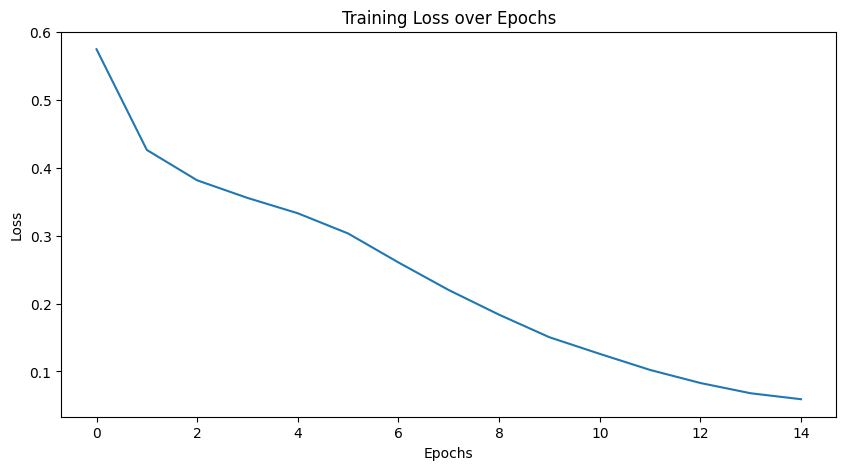

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

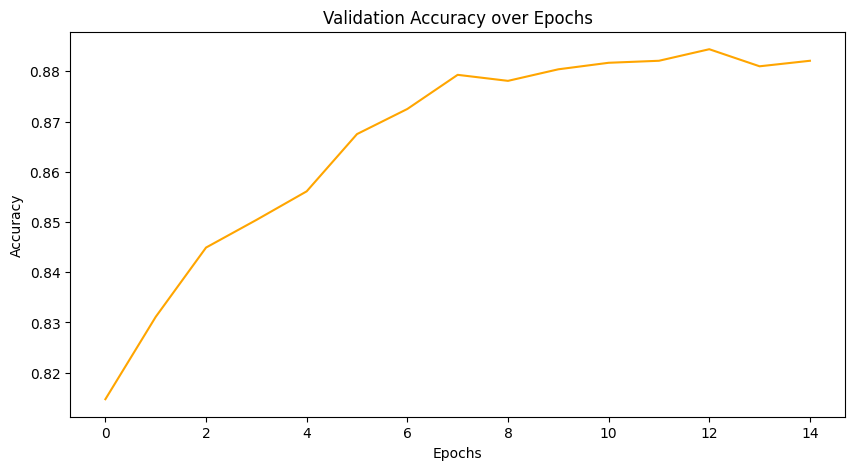

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy_list, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.show()


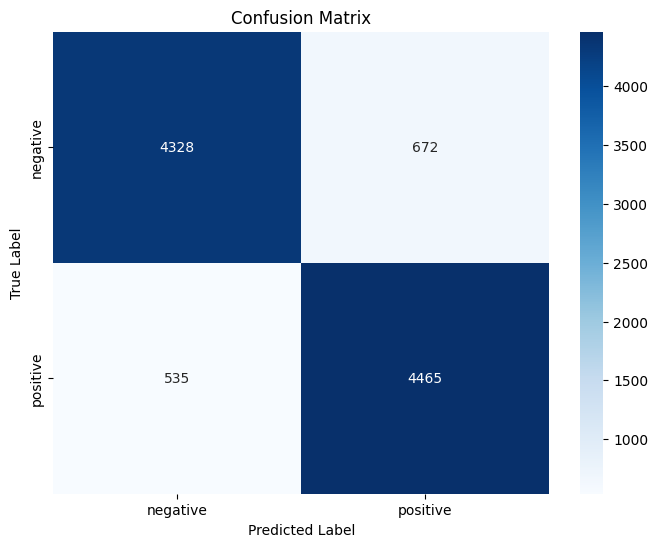

In [30]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
sample_sentence = "The movie was fantastic with stunning visuals and a really good storyline."
sample_tokens = word_tokenize(preprocess_text(sample_sentence))
sample_indices = torch.tensor([vocab(sample_tokens)], dtype=torch.long).to(device)
with torch.no_grad():
    output = model(sample_indices)
    predicted_prob = torch.sigmoid(output).item()
    predicted_class = 1 if predicted_prob >= 0.5 else 0
print(f"Sample Sentence: {sample_sentence}")
print(f"Predicted Class: {'positive' if predicted_class == 1 else 'negative'}, Probability: {predicted_prob:.4f}")


Sample Sentence: The movie was fantastic with stunning visuals and a really good storyline.
Predicted Class: positive, Probability: 0.9507
